In [ ]:
!pip install torch torchvision

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from google.colab import drive

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
drive.mount('/content/drive')
data_dir = '/content/drive/My Drive/data'

Mounted at /content/drive


# Transformations pour les ensembles d'entraînement et de validation

In [ ]:
transform = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalisation ImageNet
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
}

Charger les jeux de données depuis Google Drive

In [ ]:
train_dataset = datasets.ImageFolder(f'{data_dir}/train', transform=transform["train"])
test_dataset = datasets.ImageFolder(f'{data_dir}/test', transform=transform["val"])


 Division des données d'entraînement en ensembles d'entraînement et de validation

In [ ]:
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Modèles pré-entraînés

In [ ]:
efficientnet = models.efficientnet_b0(weights='IMAGENET1K_V1').to(device)
mobilenet = models.mobilenet_v2(weights='IMAGENET1K_V1').to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 107MB/s] 
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 130MB/s]


Remplacer la dernière couche pour la classification binaire

In [ ]:
efficientnet.classifier[1] = nn.Linear(efficientnet.classifier[1].in_features, 1).to(device)
mobilenet.classifier[1] = nn.Linear(mobilenet.classifier[1].in_features, 1).to(device)


Définir la fonction de perte et les optimisateurs

In [ ]:
criterion = nn.BCEWithLogitsLoss()  # Fonction de perte pour la classification binaire
optimizer_efficientnet = optim.Adam(efficientnet.parameters(), lr=1e-4)
optimizer_mobilenet = optim.Adam(mobilenet.parameters(), lr=1e-4)


Fonction pour entraîner le modèle avec validation et early stopping

In [ ]:
def train_model_with_validation(model, train_loader, val_loader, criterion, optimizer, epochs=20, patience=3):
    best_val_loss = float('inf')
    epochs_without_improvement = 0  # Compteur d'époques sans amélioration
    model.train()

    # Suivi des pertes et des précisions
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # Entraînement
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  # Réinitialiser les gradients
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())  # Loss binaire
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), labels.float())  # Loss binaire
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_without_improvement = 0  # Réinitialiser le compteur
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print("Early stopping triggered")
            break

        model.train()

    return model, train_losses, val_losses


Entraîner les deux modèles avec validation et early stopping

In [ ]:
efficientnet_trained, train_losses_efficientnet, val_losses_efficientnet = train_model_with_validation(
    efficientnet, train_loader, val_loader, criterion, optimizer_efficientnet, epochs=10, patience=3)

mobilenet_trained, train_losses_mobilenet, val_losses_mobilenet = train_model_with_validation(
    mobilenet, train_loader, val_loader, criterion, optimizer_mobilenet, epochs=10, patience=3)


Epoch 1/10, Train Loss: 0.4954, Val Loss: 0.3592
Epoch 2/10, Train Loss: 0.3405, Val Loss: 0.2882
Epoch 3/10, Train Loss: 0.2865, Val Loss: 0.2844
Epoch 4/10, Train Loss: 0.2641, Val Loss: 0.2595
Epoch 5/10, Train Loss: 0.2271, Val Loss: 0.2763
Epoch 6/10, Train Loss: 0.2177, Val Loss: 0.2510
Epoch 7/10, Train Loss: 0.2010, Val Loss: 0.2537
Epoch 8/10, Train Loss: 0.1870, Val Loss: 0.2548
Epoch 9/10, Train Loss: 0.1702, Val Loss: 0.2679
Early stopping triggered
Epoch 1/10, Train Loss: 0.4116, Val Loss: 0.2686
Epoch 2/10, Train Loss: 0.2954, Val Loss: 0.3103
Epoch 3/10, Train Loss: 0.2742, Val Loss: 0.2236
Epoch 4/10, Train Loss: 0.2492, Val Loss: 0.2734
Epoch 5/10, Train Loss: 0.2419, Val Loss: 0.2441
Epoch 6/10, Train Loss: 0.2109, Val Loss: 0.2551
Early stopping triggered


Fonction de visualisation des courbes de perte

In [ ]:
def plot_loss_curves(train_losses, val_losses, model_name):
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Loss Curves for {model_name}')
    plt.legend()
    plt.show()

Courbes de perte pour EfficientNet et MobileNet

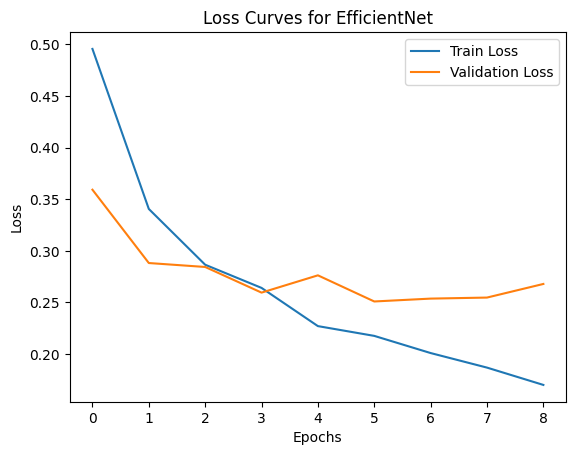

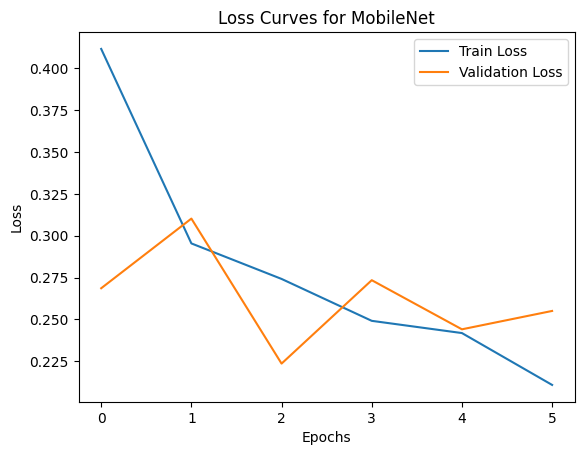

In [ ]:
plot_loss_curves(train_losses_efficientnet, val_losses_efficientnet, 'EfficientNet')
plot_loss_curves(train_losses_mobilenet, val_losses_mobilenet, 'MobileNet')


Fonction pour tester le modèle et afficher les résultats

In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.sigmoid(outputs).squeeze() > 0.5  # Seuil pour la classification binaire
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Accuracy: {accuracy:.4f}")

    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Benign", "Malignant"], yticklabels=["Negative", "Positive"])
    plt.title("Confusion Matrix")
    plt.show()

Évaluation des modèles sur l'ensemble de test

Evaluating EfficientNet:
Accuracy: 0.8985


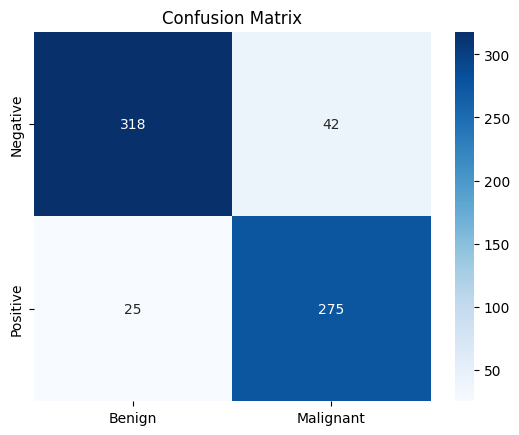

Evaluating MobileNet:
Accuracy: 0.8561


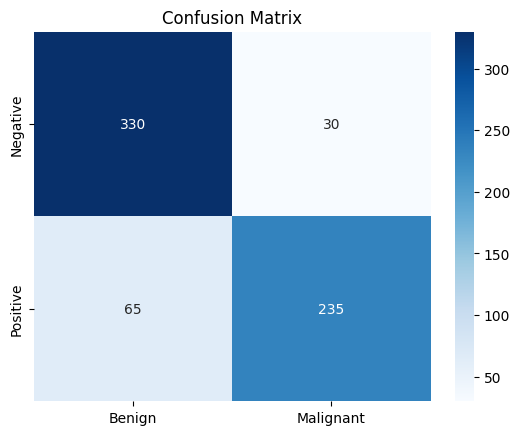

In [ ]:
print("Evaluating EfficientNet:")
evaluate_model(efficientnet_trained, test_loader)

print("Evaluating MobileNet:")
evaluate_model(mobilenet_trained, test_loader)

In [ ]:
from google.colab import files
torch.save(efficientnet_trained.state_dict(), "model.pt") # Saving EfficientNet
# Télécharger le fichier model.pt
files.download("model.pt")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>